# Задание
`Основные цели этого задания:`

- Научиться работать с новыми моделями: случайный лес, градиентный бустинг.

- Научиться распознавать факты переобучения и недообучения модели.

- Научить бороться с переобучением и недообучением модели путем варьирования ее гиперпараметров.

`Задача:`

> Построить модель машинного обучения, предсказывающую, является ли `вино красным `по одиннадцати его характеристикам.

`План решения:`

- Загрузите данные, объедините источники в один датафрейм. 
- Составьте целевую переменную на основе файла, из которого вы получили часть данных, изучите распределение по ней. 
- Проверьте отсутствие пропусков в данных, отделите фичи и целевой признак друг от друга, разделите данные на обучающую и валидационную части.

> Поскольку выборка несбалансирована, воспользуемся для оценки качества модели новой метрикой balanced_accuracy_score. Изучите формулу расчета метрики в документации и реализуйте функцию balanced_accuracy_score_my для ее расчета. На вход она должна принимать правильные и прогнозные метки классов, а возвращать число от 0 до 1. Убедитесь, что вы корректно реализовали расчет, сравнив значения, получаемые библиотечной реализацией и собственной, подавая на вход векторы:
y_true =  [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

`Подберите лучшую модель решающего дерева:`

1. Переберите несколько значений какого-либо гиперпараметра, отвечающего за сложность дерева, для каждого значения оцените качество на обучающей и валидационной частях

2. Визуализируйте зависимость качества модели от значения гиперпараметров. Опишите зоны недообучения и переобучения, если вы их наблюдаете.

3. Выведите значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 

`Подберите лучшую модель случайного леса:`

1. Переберите несколько значений какого-либо гиперпараметра дерева и для каждого из них — несколько значений гиперпараметра, отвечающего за количество решающих деревьев в случайном лесу. Для каждой комбинации гиперпараметров оцените качество на валидационной части.

2. Визуализируйте зависимость качества модели от значений гиперпараметров с помощью функции imshow. `Опишите особенности, которые вы наблюдаете.`

3. Выведите значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее.

`Подберите лучший вариант градиентного бустинга:`

1. Выделите из обучающей части данных часть для валидации градиентного бустинга в ходе обучения.

3. Зафиксируйте небольшое количество деревьев, значение какого-либо параметра, отвечающего за сложность решающих деревьев и значение величины шага градиентного бустинга. Обучите градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведите значение метрики качества на экран.

4. На фиксированном небольшом количестве деревьев сравните 3-4 комбинации значений параметров величины шага градиентного бустинга и какого-либо параметра, отвечающего за сложность решающих деревьев.

5. Выберите из рассмотренных комбинаций лучшую и обоснуйте свой выбор.

6. Увеличьте количество деревьев и опишите эффект. Изучите значение гиперпараметра early_stopping_rounds и воспользуйтесь им, чтобы сэкономить время, войдя в переобучение модели.

`В выводах напишите, какая модель показала себя лучше всего, какого качества удалось достичь.`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb

from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, scale, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


`Загружаю данные, объединяю источники в один датафрейм. `

In [2]:
df_red = pd.read_csv('winequality-red.csv', sep=';', encoding='utf-8')
df_white = pd.read_csv('winequality-white.csv', sep=';', encoding='utf-8')

# определяю целевую переменную. 1 - красное вино 0 - белое вино 
df_red['target'] = 1
df_white['target'] = 0


pd.set_option('display.max_columns', None)
ar,br = df_red.shape
aw,bw = df_white.shape
print(f'число строк в df_red = {ar},\nчисло столбцов в df_red = {br}')
print(f'число строк в df_white = {aw},\nчисло столбцов в df_white = {bw}')

df = pd.concat([df_red,df_white])
df_l, df_c = df.shape
print(f'число строк в общем DF = {df_l},\nчисло столбцов в общем DF = {df_c}')

число строк в df_red = 1599,
число столбцов в df_red = 13
число строк в df_white = 4898,
число столбцов в df_white = 13
число строк в общем DF = 6497,
число столбцов в общем DF = 13


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  target                6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


In [4]:
df.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
4075,5.7,0.25,0.26,12.5,0.049,52.5,120.0,0.99691,3.08,0.45,9.4,6,0
3544,6.0,0.33,0.20,1.8,0.031,49.0,159.0,0.99190,3.41,0.53,11.0,6,0
1133,8.7,0.22,0.42,2.3,0.053,27.0,114.0,0.99400,2.99,0.43,10.0,5,0


- в получившимся датафрейме `6497` строк и `13` столбцов\
fixed acidity - фиксированная кислотность\
volatile acidity - летучая кислотность\
citric acid - лимонная кислота\
residual sugar - остаточный сахар\
chlorides - хлориды\
free sulfur dioxide - свободный диоксид серы\
total sulfur dioxide - общий диоксид серы\
density - плотность\
pH - индекс pH\
sulphates - сульфаты\
alcohol - алкоголь\
quality - качество




- переименовал столбцы (убрал пробелы в названиях)
- заменил тип столбца quality на числовой

In [5]:
df = df.rename(columns=lambda x: x.replace(' ', '_'))

In [6]:
print(f'Количество дубликатов в DataFrame = {df.duplicated().sum()}')

Количество дубликатов в DataFrame = 1177


Убираем одинаковые строки

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
print(f'    Количество NaN в DataFrame \n{"-"*50}\n{df.isna().sum()}')

    Количество NaN в DataFrame 
--------------------------------------------------
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
target                  0
dtype: int64


- NaN значений нет

- Посмотрим на значения средних, медианных значений двух вин в их характеристиках

In [9]:
df.describe().round(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,target
count,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00
mean,7.22,0.34,0.32,5.05,0.06,30.04,114.11,0.99,3.22,0.53,10.55,5.80,0.26
std,1.32,0.17,0.15,4.50,0.04,17.81,56.77,0.00,0.16,0.15,1.19,0.88,0.44
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00,0.00
25%,6.40,0.23,0.24,1.80,0.04,16.00,74.00,0.99,3.11,0.43,9.50,5.00,0.00
50%,7.00,0.30,0.31,2.70,0.05,28.00,116.00,0.99,3.21,0.51,10.40,6.00,0.00
75%,7.70,0.41,0.40,7.50,0.07,41.00,153.25,1.00,3.33,0.60,11.40,6.00,1.00
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,9.00,1.00


Диаграмма распределения качества вина по категориям

In [10]:
fig = px.pie(df, values='quality', names='quality', title='Распределение качества')
fig.update_layout(width=800, height=800)
fig.show()

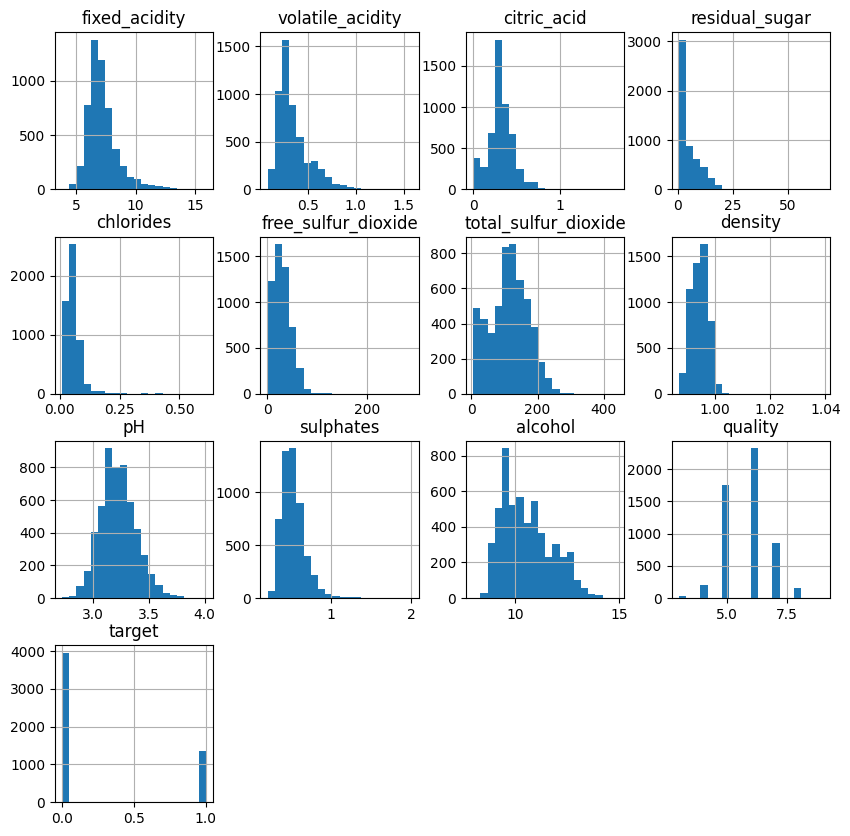

In [11]:
df.hist(bins=20, figsize=(10, 10))
plt.show()

1 - красное вино 0 - белое вино 

- Видно, какие все таки они разные. По многим значениям имеются существенные различия !

Коэффициент корреляции Пирсона между качеством и другими атрибутами
>Коэффициент корреляции Пирсона показывает степень линейной зависимости между двумя непрерывными переменными. Измеряет силу и направление связи между переменными и может принимать значения от -1 до 1.
>Значение коэффициента корреляции Пирсона:
- Близкое к 1 указывает на положительную линейную связь, то есть, при увеличении одной переменной, другая переменная также увеличивается.
- Близкое к -1 указывает на отрицательную линейную связь, то есть, при увеличении одной переменной, другая переменная уменьшается.
- Значение близкое к 0 указывает на отсутствие линейной связи между переменными.

In [12]:
print(df.corr().quality)

fixed_acidity          -0.080092
volatile_acidity       -0.265205
citric_acid             0.097954
residual_sugar         -0.056830
chlorides              -0.202137
free_sulfur_dioxide     0.054002
total_sulfur_dioxide   -0.050296
density                -0.326434
pH                      0.039733
sulphates               0.041884
alcohol                 0.469422
quality                 1.000000
target                 -0.114809
Name: quality, dtype: float64


- имеются 2 параметра сильно коррелирующие с качеством\
alcohol                 0.444319\
volatile acidity       -0.265699

- Среднее распределение летучих характеристик кислотности и качества, соответствующих каждому качеству

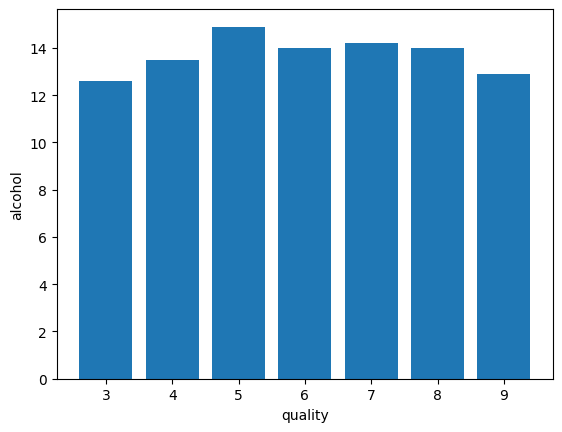

In [13]:
plt.bar(df['quality'], df['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()

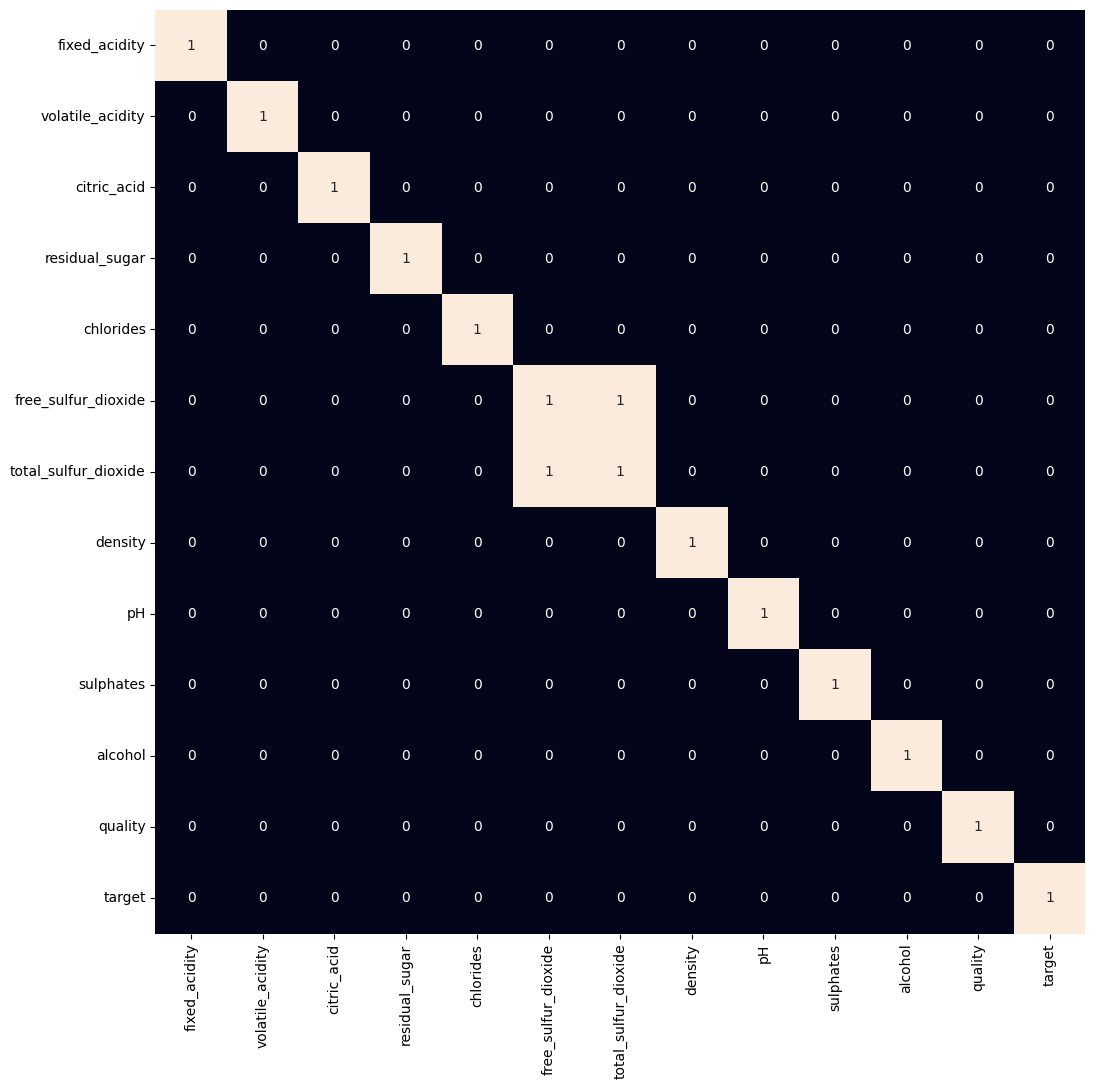

In [14]:
plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

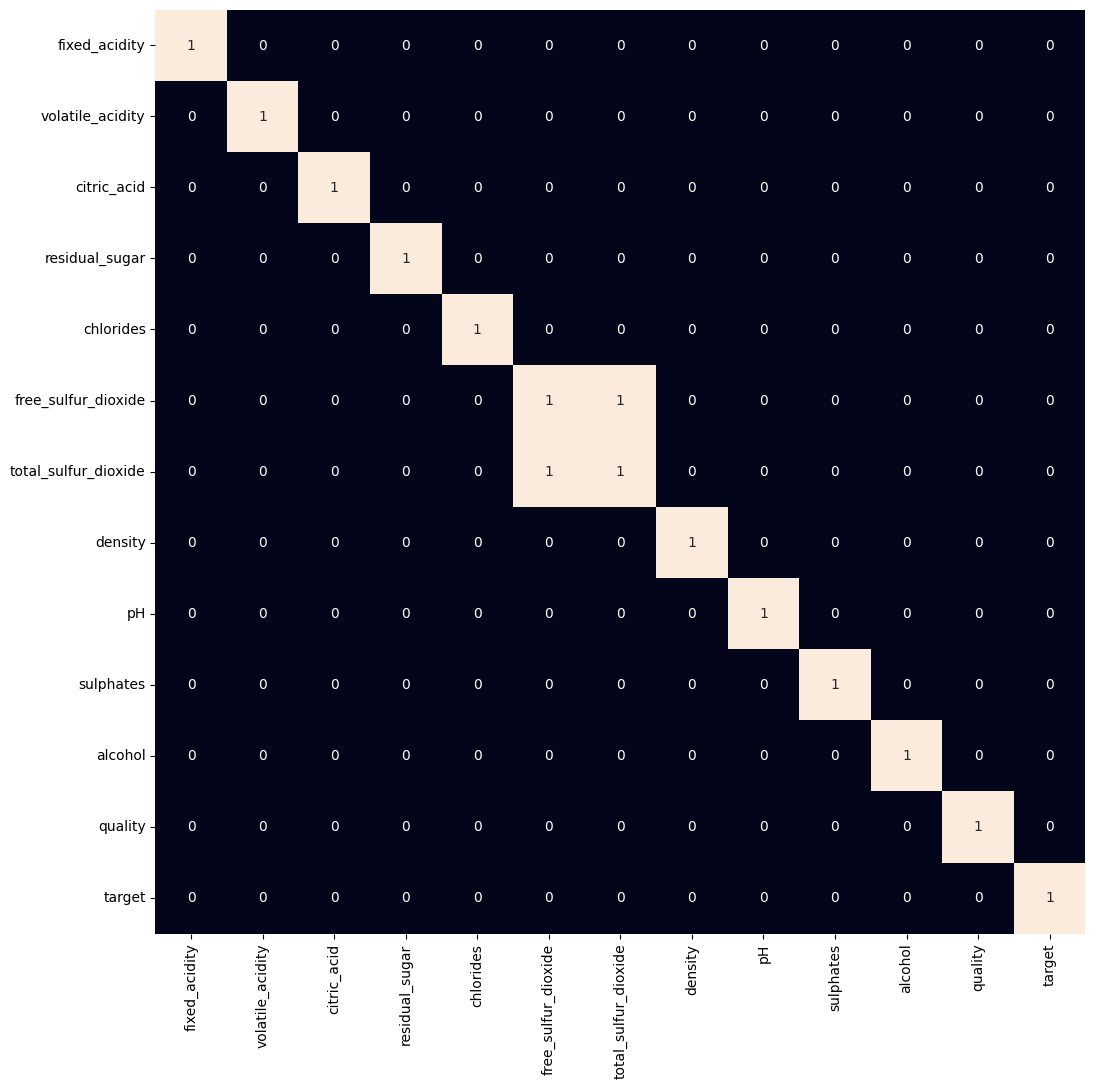

In [ ]:
plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

Из приведенной выше тепловой карты можно сделать вывод, что "общий диоксид серы" и "свободный диоксид серы‘ являются сильно коррелирующими характеристиками, поэтому мы их удалим.

In [15]:
df = df.drop('total_sulfur_dioxide', axis=1)

In [16]:
df.head(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,0.9970,3.26,0.65,9.8,5,1


------
Реализация функции  `balanced_accuracy_score_my`  на основе формулы расчета метрики сбалансированной точности

In [17]:
def balanced_accuracy_score_my(y_true, y_pred):
    tp = 0  # True Positive
    tn = 0  # True Negative
    fp = 0  # False Positive
    fn = 0  # False Negative

    for true, pred in zip(y_true, y_pred):
        if true == pred:
            if true == 1:
                tp += 1
            else:
                tn += 1
        else:
            if true == 1:
                fn += 1
            else:
                fp += 1

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    balanced_accuracy = (sensitivity + specificity) / 2

    return balanced_accuracy

In [18]:
y_true = [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

my_score = balanced_accuracy_score_my(y_true, y_pred)
sklearn_score = balanced_accuracy_score(y_true, y_pred)

print("Собственная реализация:", my_score)
print("Библиотечная реализация:", sklearn_score)

Собственная реализация: 0.6071428571428572
Библиотечная реализация: 0.6071428571428572


У нас удалось повторить точность библиотечной модели

-----
`Составляю целевую переменную на основе файла, из которого вы получил часть данных, изучаю распределение по ней.`

In [19]:
features, target = df.drop(columns='target'), df['target']

features_train_xgb, features_val, target_train_xgb, target_val = train_test_split(features, target, test_size=0.25, random_state=42)

features_train_xgb.shape, features_val.shape

((3990, 11), (1330, 11))

Нормализация данных перед обучением (помогает нам добиться стабильного и быстрого обучения модели.)

In [20]:
norm = MinMaxScaler()
features_train_xgb = norm.fit_transform(features_train_xgb)
features_val = norm.transform(features_val)

-------------
`Подберите лучшую модель решающего дерева:`

1. Переберите несколько значений какого-либо гиперпараметра, отвечающего за сложность дерева, для каждого значения оцените качество на обучающей и валидационной частях

2. Визуализируйте зависимость качества модели от значения гиперпараметров. Опишите зоны недообучения и переобучения, если вы их наблюдаете.

3. Выведите значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 

график зависимости качества модели от значения  `max_depth`

 `max_depth`  - это гиперпараметр, который относится к моделям решающих деревьев. Он определяет максимальную глубину дерева решений, то есть максимальное количество разделений или уровней, которые дерево может иметь. 

Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке: 9
Максимальное качество модели на тестовой выборке: 0.9719465511014806
Максимальное качество модели на тренировочной выборке: 0.999003984063745


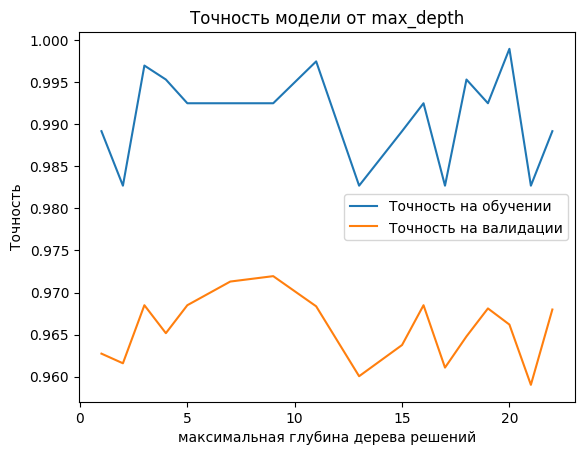

In [33]:
param_grid = {'max_depth': [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22]}
train_scores = []
test_scores = []

for max_depth in param_grid['max_depth']:
    tree_model = DecisionTreeClassifier(max_depth=max_depth)
    grid_search = GridSearchCV(tree_model, param_grid, cv=5)
    grid_search.fit(features_train_xgb, target_train_xgb)
    train_accuracy = balanced_accuracy_score(target_train_xgb, grid_search.predict(features_train_xgb))
    test_accuracy = balanced_accuracy_score(target_val, grid_search.predict(features_val))
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

max_test_accuracy = max(test_scores)
max_train_accuracy = max(train_scores)

best_max_depth = param_grid['max_depth'][test_scores.index(max_test_accuracy)]
print("Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке:", best_max_depth)

print("Максимальное качество модели на тестовой выборке:", max_test_accuracy)
print("Максимальное качество модели на тренировочной выборке:", max_train_accuracy)

plt.plot(param_grid['max_depth'], train_scores, label='Точность на обучении')
plt.plot(param_grid['max_depth'], test_scores, label='Точность на валидации')
plt.xlabel('максимальная глубина дерева решений')
plt.ylabel('Точность')
plt.title('Точность модели от max_depth')
plt.legend()
plt.show()

`ВЫВОД:`

Установка значения  `max_depth`  позволяет контролировать сложность модели решающего дерева. Маленькое значение  `max_depth`  создает более простое дерево с меньшим количеством разделений, что может привести к `недообучению` модели. С другой стороны, `большое` значение  `max_depth`  может привести к `переобучению`, когда дерево слишком хорошо запоминает обучающие данные и не обобщает их на новые данные.

Влияние параметра  `max_depth`  на модель включает:

1. Сложность модели: Увеличение значения  `max_depth`  приводит к более сложной модели, которая может лучше подстраиваться под обучающие данные. Большая глубина дерева позволяет модели выявить более сложные зависимости в данных.

2. Переобучение: Если значение  `max_depth`  слишком большое, модель может стать переобученной, то есть она будет хорошо предсказывать обучающие данные, но плохо обобщать на новые данные. Это может привести к низкой обобщающей способности модели.

3. Недообучение: Если значение  `max_depth`  слишком маленькое, модель может быть недообученной, то есть она не сможет уловить сложные зависимости в данных и будет иметь низкую точность.

4. Время обучения: Увеличение значения  `max_depth`  может увеличить время обучения модели, поскольку каждое разделение данных требует вычислительных ресурсов.

>Выбор оптимального значения  `max_depth`  является важным шагом при построении модели решающего дерева.\
>Оптимальное значение  `max_depth`  зависит от конкретной задачи, размера и сложности данных.\
 Часто требуется провести подбор гиперпараметров, чтобы найти\
>оптимальное значение  `max_depth`  для достижения наилучшей производительности модели.

--------------
`Подберите лучшую модель случайного леса:`

1. Переберите несколько значений какого-либо гиперпараметра дерева и для каждого из них — несколько значений гиперпараметра, отвечающего за количество решающих деревьев в случайном лесу. Для каждой комбинации гиперпараметров оцените качество на валидационной части.

2. Визуализируйте зависимость качества модели от значений гиперпараметров с помощью функции imshow. `Опишите особенности, которые вы наблюдаете.`

3. Выведите значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее.

Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке: 8
Значение гиперпараметра n_estimators с наилучшим качеством на валидационной выборке: 206
Максимальное качество модели на тестовой выборке: 0.9870639219934995
Максимальное качество модели на тренировочной выборке: 0.996179048040924


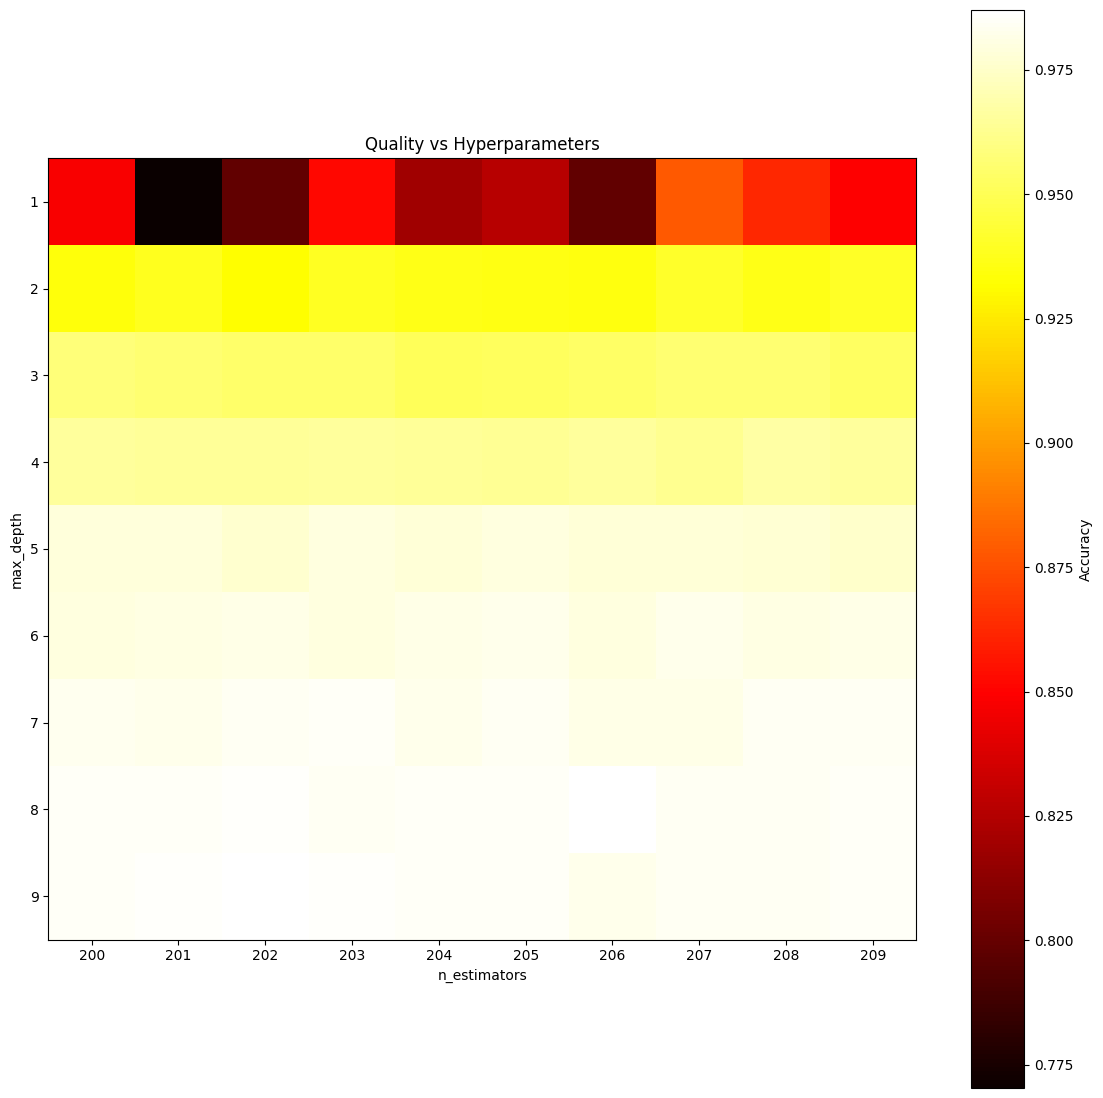

In [31]:
param_grid_rfc_hm = {
    'n_estimators': list(range(200, 210)),
    'max_depth': list(range(1, 10))
}

train_scores = []
test_scores = []
best_max_depth_index_rf = 0
best_n_estimators_index_rf = 0
max_test_accuracy = 0

for max_depth in param_grid_rfc_hm['max_depth']:
    for n_estimators in param_grid_rfc_hm['n_estimators']:
        rf_model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
        rf_model.fit(features_train_xgb, target_train_xgb)
        train_accuracy = balanced_accuracy_score(target_train_xgb, rf_model.predict(features_train_xgb))
        test_accuracy = balanced_accuracy_score(target_val, rf_model.predict(features_val))
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
        
        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            best_max_depth_index_rf = max_depth
            best_n_estimators_index_rf = n_estimators

max_train_accuracy = max(train_scores)

print("Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке:", best_max_depth_index_rf)
print("Значение гиперпараметра n_estimators с наилучшим качеством на валидационной выборке:", best_n_estimators_index_rf)
print("Максимальное качество модели на тестовой выборке:", max_test_accuracy)
print("Максимальное качество модели на тренировочной выборке:", max_train_accuracy)

quality_matrix = np.array(test_scores).reshape(len(param_grid_rfc_hm['max_depth']), len(param_grid_rfc_hm['n_estimators']))

plt.figure(figsize=(14, 14))  # Задаем размер фигуры

plt.imshow(quality_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(ticks=np.arange(len(param_grid_rfc_hm['n_estimators'])), labels=param_grid_rfc_hm['n_estimators'])
plt.yticks(ticks=np.arange(len(param_grid_rfc_hm['max_depth'])), labels=param_grid_rfc_hm['max_depth'])
plt.title('Quality vs Hyperparameters')
plt.show()

- на тепловой карте четко отображается значение наибольшей точности модели (самый светлый цвет) `Очень удобно проводить анализ`

Если точность на тестовой выборке равна максимальным значениям, используется красный цвет для отображения точки на графике
Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке: 8
Значение гиперпараметра n_estimators с наилучшим качеством на валидационной выборке: 204
Максимальное качество модели на тестовой выборке: 0.98757674250632
Максимальное качество модели на тренировочной выборке: 0.9963464961320159


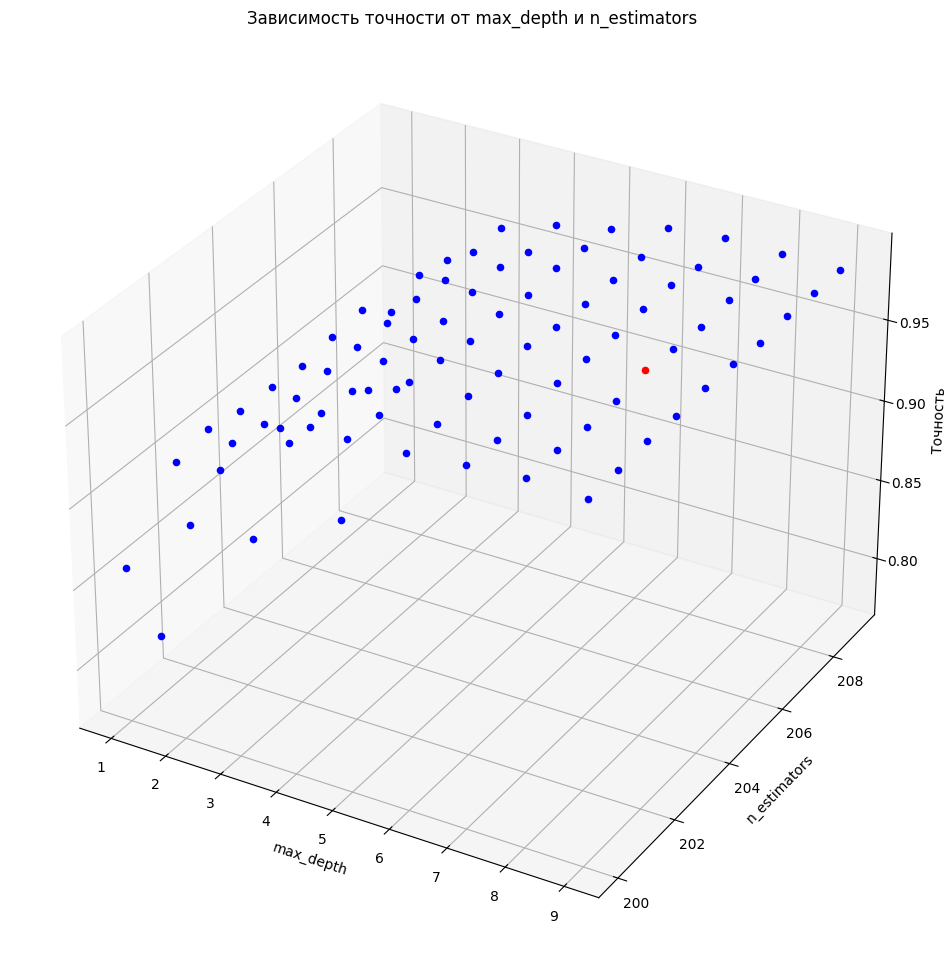

In [32]:
param_grid_rfc_3d = {
    'n_estimators': list(range(200, 210)),
    'max_depth': list(range(1, 10))
}

train_scores = []
test_scores = []
best_max_depth = 0
best_n_estimators = 0
max_test_accuracy = 0

for max_depth in param_grid_rfc_3d['max_depth']:
    for n_estimators in param_grid_rfc_3d['n_estimators']:
        rf_model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
        rf_model.fit(features_train_xgb, target_train_xgb)
        train_accuracy = balanced_accuracy_score(target_train_xgb, rf_model.predict(features_train_xgb))
        test_accuracy = balanced_accuracy_score(target_val, rf_model.predict(features_val))
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
        
        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            best_max_depth = max_depth
            best_n_estimators = n_estimators

max_train_accuracy = max(train_scores)

print("\033[1mЕсли точность на тестовой выборке равна максимальным значениям, используется красный цвет для отображения точки на графике\033[0m")
print("Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке:", best_max_depth)
print("Значение гиперпараметра n_estimators с наилучшим качеством на валидационной выборке:", best_n_estimators)
print("Максимальное качество модели на тестовой выборке:", max_test_accuracy)
print("Максимальное качество модели на тренировочной выборке:", max_train_accuracy)

max_depth_values = param_grid_rfc_hm['max_depth']
n_estimators_values = param_grid_rfc_hm['n_estimators']
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for i, max_depth in enumerate(max_depth_values):
    for j, n_estimators in enumerate(n_estimators_values):
        accuracy = test_scores[i * len(n_estimators_values) + j]
        if max_depth == best_max_depth and n_estimators == best_n_estimators:
            ax.scatter(max_depth, n_estimators, accuracy, c='r', marker='o')
        else:
            ax.scatter(max_depth, n_estimators, accuracy, c='b', marker='o')
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('Точность')
plt.title('Зависимость точности от max_depth и n_estimators')
plt.show()

`ВЫВОДЫ:`

Гиперпараметры  `max_depth`  и  `n_estimators`  в модели `RandomForestClassifier` имеют следующее влияние:

1.  `max_depth` : Этот гиперпараметр определяет максимальную глубину каждого дерева в случайном лесу. Увеличение значения  `max_depth`  может привести к более `сложным деревьям`, которые могут `лучше` подстраиваться `под обучающие данные`. Однако, слишком большое значение  `max_depth`  может привести к переобучению модели. Обычно рекомендуется подбирать оптимальное значение  `max_depth`  с помощью `кросс-валидации`.

2.  `n_estimators` : Этот гиперпараметр определяет количество деревьев в случайном лесу. `Увеличение` значения  `n_estimators`  может `улучшить` `стабильность` и `точность` модели, так как случайный лес с большим количеством деревьев имеет больше возможностей для `усреднения` `предсказаний`. Однако, слишком `большое` значение  `n_estimators`  может привести к `увеличению` `времени` обучения модели.

>Важно отметить, что оптимальные значения  `max_depth`  и  `n_estimators`  зависят от `конкретной` задачи, `размера` и `сложности` данных. Рекомендуется проводить подбор гиперпараметров с использованием `кросс-валидации` для достижения наилучшей производительности при применении модели RandomForestClassifier.

-------------
`Подберите лучший вариант градиентного бустинга:`

1. Выделите из обучающей части данных часть для валидации градиентного бустинга в ходе обучения.

3. Зафиксируйте небольшое количество деревьев, значение какого-либо параметра, отвечающего за сложность решающих деревьев и значение величины шага градиентного бустинга. Обучите градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведите значение метрики качества на экран.

4. На фиксированном небольшом количестве деревьев сравните 3-4 комбинации значений параметров величины шага градиентного бустинга и какого-либо параметра, отвечающего за сложность решающих деревьев.

5. Выберите из рассмотренных комбинаций лучшую и обоснуйте свой выбор.

6. Увеличьте количество деревьев и опишите эффект. Изучите значение гиперпараметра early_stopping_rounds и воспользуйтесь им, чтобы сэкономить время, войдя в переобучение модели.


In [51]:
features_train_xgb, features_val, target_train_xgb, target_val = train_test_split(features_train_xgb, target_train_xgb, test_size=0.15, random_state=55)

In [58]:
model = XGBClassifier(n_estimators = 10, max_depth=10, learning_rate = 1)
model.fit(features_train_xgb, target_train_xgb, eval_set=[(features_train_xgb,target_train_xgb), (features_val, target_val)])
pred_train = model.predict(features_train_xgb)
pred_test = model.predict(features_val)

print(f'Accuracy train:{accuracy_score(pred_train,target_train_xgb)}')
print(f'Accuracy test:{accuracy_score(pred_test,target_val)}')

[0]	validation_0-logloss:0.13676	validation_1-logloss:0.17024
[1]	validation_0-logloss:0.06113	validation_1-logloss:0.10425
[2]	validation_0-logloss:0.03268	validation_1-logloss:0.07663
[3]	validation_0-logloss:0.01874	validation_1-logloss:0.06626
[4]	validation_0-logloss:0.01205	validation_1-logloss:0.05803
[5]	validation_0-logloss:0.00899	validation_1-logloss:0.05410
[6]	validation_0-logloss:0.00708	validation_1-logloss:0.05599
[7]	validation_0-logloss:0.00590	validation_1-logloss:0.05963
[8]	validation_0-logloss:0.00500	validation_1-logloss:0.05855
[9]	validation_0-logloss:0.00441	validation_1-logloss:0.05723
Accuracy train:0.9974937343358395
Accuracy test:0.987218045112782


Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке: 6
Значение гиперпараметра learning_rate с наилучшим качеством на валидационной выборке: 0.3
Значение гиперпараметра n_estimators с наилучшим качеством на валидационной выборке: 6
Максимальное качество модели на тестовой выборке: 0.9748554365342688
Максимальное качество модели на тренировочной выборке: 0.9961435958740725


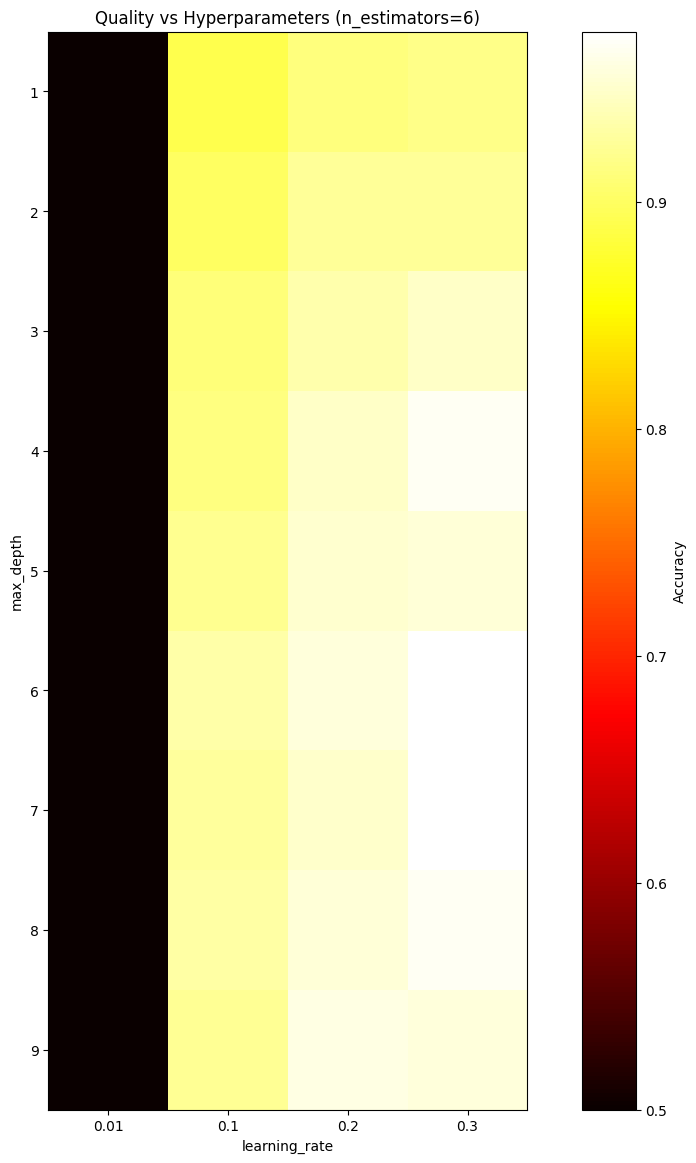

In [62]:
param_grid_xgb = {
    'max_depth': list(range(1, 10)),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': list(range(1, 11))
}

train_scores_xgb = []
test_scores_xgb = []
best_max_depth_index_xgb = 0
best_learning_rate_index_xgb = 0
best_n_estimators_index_xgb = 0
max_test_accuracy_xgb = 0

for max_depth in param_grid_xgb['max_depth']:
    for learning_rate in param_grid_xgb['learning_rate']:
        for n_estimators in param_grid_xgb['n_estimators']:
            xgb_model = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
            xgb_model.fit(features_train_xgb, target_train_xgb)
            train_accuracy_xgb = balanced_accuracy_score(target_train_xgb, xgb_model.predict(features_train_xgb))
            test_accuracy_xgb = balanced_accuracy_score(target_val, xgb_model.predict(features_val))
            train_scores_xgb.append(train_accuracy_xgb)
            test_scores_xgb.append(test_accuracy_xgb)
            if test_accuracy_xgb > max_test_accuracy_xgb:
                max_test_accuracy_xgb = test_accuracy_xgb
                best_max_depth_index_xgb = max_depth
                best_learning_rate_index_xgb = learning_rate
                best_n_estimators_index_xgb = n_estimators

max_train_accuracy_xgb = max(train_scores_xgb)

print("Значение гиперпараметра max_depth с наилучшим качеством на валидационной выборке:", best_max_depth_index_xgb)
print("Значение гиперпараметра learning_rate с наилучшим качеством на валидационной выборке:", best_learning_rate_index_xgb)
print("Значение гиперпараметра n_estimators с наилучшим качеством на валидационной выборке:", best_n_estimators_index_xgb)
print("Максимальное качество модели на тестовой выборке:", max_test_accuracy_xgb)
print("Максимальное качество модели на тренировочной выборке:", max_train_accuracy_xgb)

quality_matrix_xgb = np.array(test_scores_xgb).reshape(len(param_grid_xgb['max_depth']), len(param_grid_xgb['learning_rate']), len(param_grid_xgb['n_estimators']))
plt.figure(figsize=(14, 14))
plt.imshow(quality_matrix_xgb[:, :, best_n_estimators_index_xgb-1], cmap='hot', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('learning_rate')
plt.ylabel('max_depth')
plt.xticks(ticks=np.arange(len(param_grid_xgb['learning_rate'])), labels=param_grid_xgb['learning_rate'])
plt.yticks(ticks=np.arange(len(param_grid_xgb['max_depth'])), labels=param_grid_xgb['max_depth'])
plt.title('Quality vs Hyperparameters (n_estimators={})'.format(best_n_estimators_index_xgb))
plt.show()

`XGBClassifier` - это модель градиентного бустинга на основе деревьев решений. 
- модель XGBClassifier имеет высокую точность классификации как на обучающих, так и на тестовых данных, и может быть использована для эффективного предсказания новых данных.\
`можно сделать ВЫВОДЫ, что при увеличении количества деревьев в модели XGBClassifier возникают следующие эффекты:`\

1. `Улучшение качества предсказания:` При увеличении количества деревьев модель XGBClassifier имеет больше возможностей для обучения на данных и выявления сложных зависимостей между признаками и целевой переменной. Это может привести к улучшению качества предсказания модели.

2. `Увеличение времени обучения:` Увеличение количества деревьев требует больше вычислительных ресурсов и времени для обучения модели. Каждое дерево строится последовательно, и более сложные модели с большим количеством деревьев могут потребовать значительного времени для обучения.

3. `Увеличение риска переобучения:` При увеличении количества деревьев модель может стать более сложной и иметь больше возможностей для "`запоминания`" тренировочных данных. Это может привести к `переобучению`, когда модель `хорошо предсказывает тренировочные данные`, но `плохо` обобщает `новые` данные. Чтобы избежать переобучения, `необходимо` контролировать `глубину` деревьев и использовать регуляризацию.

4. `Увеличение стабильности предсказаний:` При `увеличении` количества деревьев модель XGBClassifier становится `более` `стабильной` в предсказаниях. Большее количество деревьев `позволяет усреднять `предсказания каждого дерева, что может `уменьшить` влияние `случайных` `шумовых` `факторов` и `улучшить` общую `стабильность` предсказаний.

>Важно найти баланс между качеством предсказания, временем обучения и риском переобучения при увеличении количества деревьев в модели XGBClassifier. Это можно сделать путем тщательного подбора гиперпараметров и использования кросс-валидации для оценки производительности модели на разных наборах данных.

------------------------
`ИТОГОВЫЕ  ВЫВОДЫ:`
- Модель `DecisionTreeClassifier` показала:\
Максимальное качество модели на тестовой выборке: 0.9719465511014806\
Максимальное качество модели на тренировочной выборке: 0.999003984063745

- Модель `RandomForestClassifier` показала:\
Максимальное качество модели на тестовой выборке: 0.98757674250632\
Максимальное качество модели на тренировочной выборке: 0.9963464961320159

- Модель `XGBClassifier` показала:\
Максимальное качество модели на тестовой выборке: 0.9748554365342688\
Максимальное качество модели на тренировочной выборке: 0.9961435958740725


На `тестовой` `выборке` с подбором гиперпараметров Модель `RandomForestClassifier` показала самые высокие результаты,
однако на `тренировочной` `выборке` лучше всего отработала Модель `DecisionTreeClassifier`. 

>Можно отметить достаточно близкую работу всех моделей на ДАННОМ ДАТАСЕТЕ. Ключевой момент в применении моделей заключается в исследуемых данных!
От характеристик датасета будет зависеть оптимальный выбор применяемой модели и ее гиперпараметров!



-------------------------